# Description

This notebook explores the use of a segmentation model to detect gastrointestinal disease

## Step 1: Obtain the dataset from the source website

In [1]:
#Check Available GPU Memory
!nvidia-smi

Thu Feb  9 10:34:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
#this code directly downloads the dataset to colab while the session runs. Once disconnected this cell has to be re-executed
!wget https://datasets.simula.no/downloads/kvasir-seg.zip

--2023-02-09 10:34:48--  https://datasets.simula.no/downloads/kvasir-seg.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46227172 (44M) [application/zip]
Saving to: ‘kvasir-seg.zip’

kvasir-seg.zip      100%[===================>]  44.08M  16.6MB/s    in 2.7s    

2023-02-09 10:34:51 (16.6 MB/s) - ‘kvasir-seg.zip’ saved [46227172/46227172]



The Dataset has been downloaded in `.zip` format. The following line of code unzips the file to access the contents

In [3]:
%%capture
!unzip "/kaggle/working/kvasir-seg.zip" -d "/kaggle/working/"

Next, we have to install the required external packages

In [4]:
%%capture
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [5]:
#Constants definition
DATA_DIR = "/kaggle/working/Kvasir-SEG/"
device = "cuda"
epoch = 15
lr = 0.003
BATCH_SIZE = 4
IMAGE_SIZE = 512
ENCODER = "timm-efficientnet-b4"
WEIGHTS = "imagenet"

## Required Library Import

In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

import albumentations as A 
import cv2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

In [7]:
#Random Seed for reproductivity of results
torch.manual_seed(3407)

In [8]:
#Helper Plotting Function
#Code Credit from Coursera Guided Projects
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        

In [9]:
#Define Image and Mask Paths
images_path = DATA_DIR + "images/"
masks_path = DATA_DIR + "masks/"

In [10]:
images_path

'/kaggle/working/Kvasir-SEG/images/'

### This Step is optional but recommended for ease of data exploration. This step extracts the path of each image and its respective mask, and stores them in a dataframe

In [11]:
imagepaths = []
maskpaths = []
imagelist=os.listdir(images_path)
masklist=os.listdir(masks_path)
for f in imagelist:
    fpath=os.path.join(images_path,f)
    imagepaths.append(fpath)

for k in masklist:
    kpath=os.path.join(masks_path,k)
    maskpaths.append(kpath)

In [12]:
Fseries = pd.Series(imagepaths, name='imagepaths')
kseries = pd.Series(maskpaths, name='maskpaths')
df = pd.concat([Fseries, kseries], axis=1)
df.head()

,imagepaths,maskpaths
0,/kaggle/working/Kvasir-SEG/images/cju5jz5fff8c...,/kaggle/working/Kvasir-SEG/masks/cju5jz5fff8c5...
1,/kaggle/working/Kvasir-SEG/images/cju2qxxko229...,/kaggle/working/Kvasir-SEG/masks/cju2qxxko229x...
2,/kaggle/working/Kvasir-SEG/images/cju16whaj0e7...,/kaggle/working/Kvasir-SEG/masks/cju16whaj0e7n...
3,/kaggle/working/Kvasir-SEG/images/cju3u1c8tfyq...,/kaggle/working/Kvasir-SEG/masks/cju3u1c8tfyqx...
4,/kaggle/working/Kvasir-SEG/images/cju7afqon1ip...,/kaggle/working/Kvasir-SEG/masks/cju7afqon1ip4...


In [13]:
#Check dataframe shape
df.shape

(1000, 2)

In [14]:
len(imagepaths)

1000

### Now Let's explore and see what a random sample of an image look like, as well as what the mask indicates and how it looks like. This helps us better understand the task and the overall objective

In [15]:
#Generate Sample 
row = df.iloc[6]
image = row.imagepaths
mask = row.maskpaths
#Using Open CV to display Image and Mask. The PIL library can also be used
image = cv2.imread(image)
mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)/ 255.0 #The mask is normalized to 255 because its in grayscale(0-255). Dividing by 255, normalizes the image to between 0 and 1

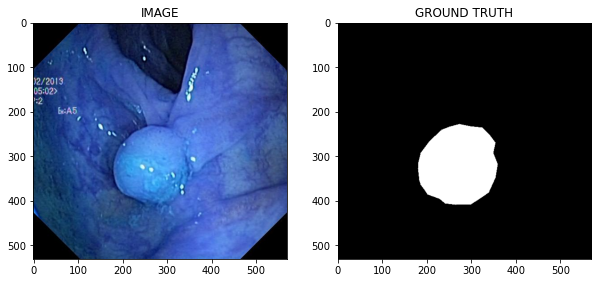

In [16]:
#Display in BGR Color. just for fun :)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

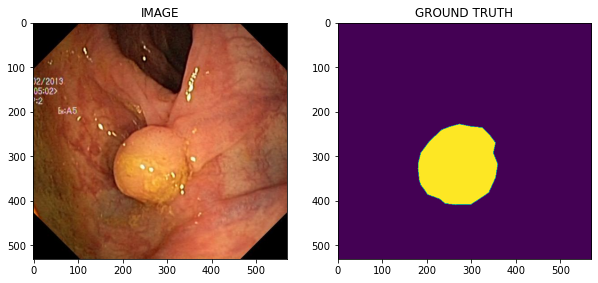

In [17]:
#Display in RGB Color Mode. This is the recommended color channel for computer vision tasks

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)

In [18]:
#Next we split the data into training and validation set
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.shape, valid_df.shape

((800, 2), (200, 2))

In [19]:
#Data Augmentation Helper Function Using Albumentation Library

def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      #A.RandomCrop(),
                    ],
      #is_check_shapes=False
  )

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
                    ],
      #is_check_shapes=False
  )

In [20]:
#Create Custom Dataset inheriting from Pytorch Dataset Class
class SEG(Dataset):
  def __init__(self, df, augmentation):
    self.df = df
    self.augmentation = augmentation #Image Transforms
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image = row.imagepaths
    mask = row.maskpaths
    image = cv2.imread(image)
    #Change Image from BGR to RGB color mode
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)/ 255.0 #Normalize Grayscale Mask to values between 0 and 1
    mask = np.expand_dims(mask, axis = -1)
    #Intialize Transformation on Image

    if self.augmentation:
      data = self.augmentation(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask))

    return image, mask


In [21]:
#Obtain tran and test set from custom segmentation dataset with data augmentation applied
trainset = SEG(train_df, get_train_augs())
validset = SEG(valid_df, get_valid_augs())

In [22]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 800
Size of Validset : 200


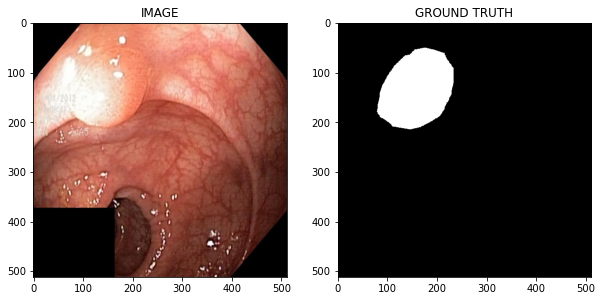

In [23]:
#view a sample image
idx = 6
images, masks = trainset[idx]
show_image(images,masks)

Notice anything? Cropping perhaps or flipped image?? :)

##### Now it's time to build the segmentation model. The model architecture used here is the U-net Convlutional network for biomedical images (Paper Link: https://arxiv.org/pdf/1505.04597.pdf).

Link to pytorch documentation here: https://smp.readthedocs.io/en/latest/quickstart.html

You can view different configurations for the model in the documentation. Such as Encoder type( Resnet variants, efficientnet, VGG etc, Weights to be applied( Imagenet is defined for most cases), activation type, etc)


In [24]:

class SegmentationModel(nn.Module):
  def __init__(self) -> None:
    super(SegmentationModel,self).__init__()
    #Define model architecture 
    self.arc = smp.Unet(
        encoder_name= ENCODER, # choose encoder, already defined above == timm-efficientnet-b4
        encoder_weights= WEIGHTS, # using `imagenet` pre-trained weights for encoder initialisation
        in_channels = 3, # model input channels (1 for gray-scale images, 3 for RGB)
        classes= 1, # model output channels (number of classes in dataset). ! in this case i.e a single segmented mask
        activation = None, #No activation here
    )

  #forward Method
  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits,masks) #See documentation for other segmentation losses
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      loss = loss1 + loss2

      return logits, loss

    return logits




In [25]:
model = SegmentationModel()
model.to(device);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_aa-818f208c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_aa-818f208c.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

In [26]:
#Define Training Loop with Backpropagation and optimimization step

def train_fn(model,data_loader,optimizer):

  #Set Model to Train mode, turn-on dropout 
  model.train() 
  total_loss = 0.0

  #training loop
  for image,mask in tqdm(data_loader):

    #Pass Image and Mask to device, same as model
    image, mask = image.to(device), mask.to(device)
 

    #Zero Grad to avoid gradient accumulation

    optimizer.zero_grad()

    #Train model, obtain predictions and loss
    logit,loss = model(image,mask)
    
    #Calculate grad
    loss.backward()

    #Update Weights

    optimizer.step()

    #Calculate Loss
    total_loss+=loss.item()

  #Calculate Loss per Batch

  avg_loss = total_loss/len(data_loader)

  return avg_loss


In [27]:
#Define Validation Function No Backpropagation needed

def val_fn(model,data_loader):

  #Set Model to Train mode, turn-off dropout
  model.eval()
  total_loss = 0.0

  #Evaluation loop

  #No Gradient Calculation or weight update(backprop) step required

  with torch.no_grad():

    for image, mask in tqdm(data_loader):
      
      image, mask = image.to(device), mask.to(device)
      logit, loss = model(image, mask)

      total_loss+= loss.item()

  avg_loss = total_loss/len(data_loader)

  return avg_loss


In [28]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)


In [29]:
#Define DataLoader
trainloader = DataLoader(trainset, batch_size=8,shuffle=True)
validloader = DataLoader(validset, batch_size=8)

In [30]:
#Clear GPU Memory
torch.cuda.empty_cache()

In [31]:
import gc
gc.collect()

5910

In [32]:
#Check GPU Memory Usage
!nvidia-smi

Thu Feb  9 10:36:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |    682MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [33]:
best_valid_loss = np.Infinity

for i in range(epoch):
  train_loss = train_fn(model,trainloader, optimizer)
  valid_loss = val_fn(model,validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-model.pt') #Save Best Model for testing
    print("Model Saved")

    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train Loss is : {train_loss}, Valid Loss is : {valid_loss}" )

100%|██████████| 25/25 [00:08<00:00,  3.09it/s]


Model Saved
Epoch: 1 Train Loss is : 0.6291518983244896, Valid Loss is : 0.9805264687538147


100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


Model Saved
Epoch: 2 Train Loss is : 0.5131531378626824, Valid Loss is : 0.46494973480701446


100%|██████████| 25/25 [00:08<00:00,  3.09it/s]


Model Saved
Epoch: 3 Train Loss is : 0.45714086458086967, Valid Loss is : 0.4076815009117126


100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


Model Saved
Epoch: 4 Train Loss is : 0.4066219970583916, Valid Loss is : 0.32393169224262236


100%|██████████| 25/25 [00:08<00:00,  3.10it/s]


Epoch: 5 Train Loss is : 0.38458128690719606, Valid Loss is : 0.41673835456371305


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Model Saved
Epoch: 6 Train Loss is : 0.3792027097195387, Valid Loss is : 0.3193317747116089


100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


Model Saved
Epoch: 7 Train Loss is : 0.330851090028882, Valid Loss is : 0.28457783699035644


100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


Epoch: 8 Train Loss is : 0.3460328769683838, Valid Loss is : 0.3911421024799347


100%|██████████| 25/25 [00:08<00:00,  3.00it/s]


Epoch: 9 Train Loss is : 0.31456922344863414, Valid Loss is : 0.3104550004005432


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


Epoch: 10 Train Loss is : 0.30215087071061136, Valid Loss is : 0.3124127334356308


100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


Epoch: 11 Train Loss is : 0.3045797602087259, Valid Loss is : 0.3412638062238693


100%|██████████| 25/25 [00:08<00:00,  2.98it/s]


Epoch: 12 Train Loss is : 0.31950118087232116, Valid Loss is : 0.3081962484121323


100%|██████████| 25/25 [00:08<00:00,  3.07it/s]


Model Saved
Epoch: 13 Train Loss is : 0.287740136384964, Valid Loss is : 0.28402466416358946


100%|██████████| 25/25 [00:08<00:00,  3.11it/s]


Epoch: 14 Train Loss is : 0.3019130387157202, Valid Loss is : 0.3107009160518646


100%|██████████| 25/25 [00:08<00:00,  3.03it/s]


Model Saved
Epoch: 15 Train Loss is : 0.270402587428689, Valid Loss is : 0.260627835392952


In [35]:
 #Model Inference
idx = 13

model.load_state_dict(torch.load("/kaggle/working/best-model.pt"))

image, mask = validset[idx]
model.to(device)

model.eval()
logits_mask = model(image.to(device).unsqueeze(0), mask.to(device).unsqueeze(0)) #Unsqueezing to switch dim from c-h-w to b-c-h-w,b=batch

pred_mask = torch.sigmoid(logits_mask[0])
pred_mask = (pred_mask > 0.5) * 1.0

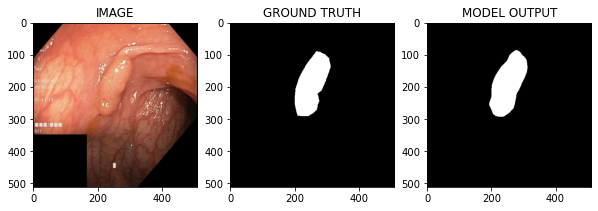

In [36]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [37]:
#Let's test our model on an Unseen test set
#this code directly downloads the dataset to colab while the session runs. Once disconnected this cell has to be re-executed
!wget https://datasets.simula.no/downloads/kvasir-sessile.zip

--2023-02-09 11:20:18--  https://datasets.simula.no/downloads/kvasir-sessile.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14434978 (14M) [application/zip]
Saving to: ‘kvasir-sessile.zip’

kvasir-sessile.zip  100%[===================>]  13.77M  9.78MB/s    in 1.4s    

2023-02-09 11:20:21 (9.78 MB/s) - ‘kvasir-sessile.zip’ saved [14434978/14434978]



In [38]:
%%capture
!unzip "/kaggle/working/kvasir-sessile.zip" -d "/kaggle/working/"

In [39]:
test_data_dir = "/kaggle/working/sessile-main-Kvasir-SEG/"
#Define Test Image and Mask Paths
test_images_path = DATA_DIR + "images/"
test_masks_path = DATA_DIR + "masks/"

In [40]:
test_imagepaths = []
test_maskpaths = []
test_imagelist=os.listdir(test_images_path)
test_masklist=os.listdir(test_masks_path)
for f in test_imagelist:
    fpath=os.path.join(test_images_path,f)
    test_imagepaths.append(fpath)

for k in test_masklist:
    kpath=os.path.join(test_masks_path,k)
    test_maskpaths.append(kpath)

In [48]:
pseries = pd.Series(test_imagepaths, name='imagepaths')
wseries = pd.Series(test_maskpaths, name='maskpaths')
test_df = pd.concat([pseries, wseries], axis=1)
test_df.head()

,imagepaths,maskpaths
0,/kaggle/working/Kvasir-SEG/images/cju5jz5fff8c...,/kaggle/working/Kvasir-SEG/masks/cju5jz5fff8c5...
1,/kaggle/working/Kvasir-SEG/images/cju2qxxko229...,/kaggle/working/Kvasir-SEG/masks/cju2qxxko229x...
2,/kaggle/working/Kvasir-SEG/images/cju16whaj0e7...,/kaggle/working/Kvasir-SEG/masks/cju16whaj0e7n...
3,/kaggle/working/Kvasir-SEG/images/cju3u1c8tfyq...,/kaggle/working/Kvasir-SEG/masks/cju3u1c8tfyqx...
4,/kaggle/working/Kvasir-SEG/images/cju7afqon1ip...,/kaggle/working/Kvasir-SEG/masks/cju7afqon1ip4...


In [49]:
test_df.shape

(1000, 2)

In [50]:
#Generate Sample 
row = test_df.iloc[6]
image = row.imagepaths
mask = row.maskpaths
#Using Open CV to display Image and Mask. The PIL library can also be used
image = cv2.imread(image)
mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)/ 255.0 #The mask is normalized to 255 because its in grayscale(0-255). Dividing by 255, normalizes the image to between 0 and 1

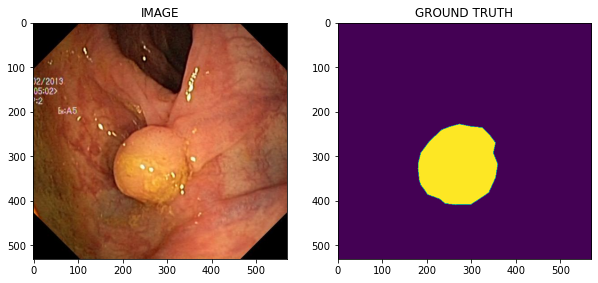

In [51]:
#Display in RGB Color Mode. This is the recommended color channel for computer vision tasks

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)

In [52]:
#use the custom dataset to transform image and mask, apply valid data augmentation
testset = SEG(test_df, get_valid_augs())


In [53]:
 #Model Inference
idx = 6

image, mask = testset[idx]
model.to(device)

model.eval()
logits_mask = model(image.to(device).unsqueeze(0), mask.to(device).unsqueeze(0)) #Unsqueezing to switch dim from c-h-w to b-c-h-w,b=batch

pred_mask = torch.sigmoid(logits_mask[0])
pred_mask = (pred_mask > 0.5) * 1.0

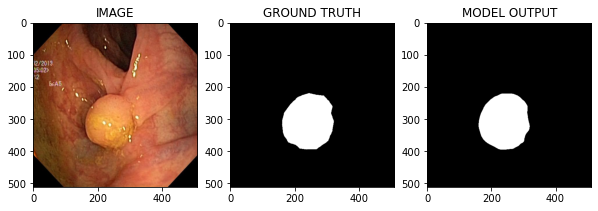

In [54]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

The model did fairly well!!
Let's try a different index

In [55]:
 #Model Inference
idx = 20

image, mask = testset[idx]
model.to(device)

model.eval()
logits_mask = model(image.to(device).unsqueeze(0), mask.to(device).unsqueeze(0)) #Unsqueezing to switch dim from c-h-w to b-c-h-w,b=batch

pred_mask = torch.sigmoid(logits_mask[0])
pred_mask = (pred_mask > 0.5) * 1.0

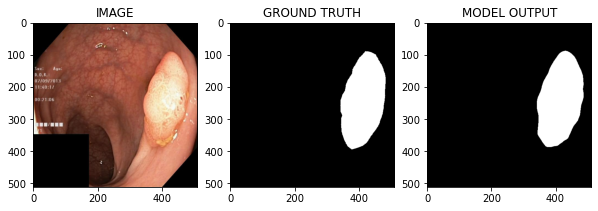

In [56]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

Nice!!